In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train_df = pd.read_csv('datasets/used_car_train_20200313.csv', sep=' ')
test_df = pd.read_csv('datasets/used_car_testA_20200313.csv', sep=' ')

print('train data shape: ', train_df.shape)
print('test data shape: ', test_df.shape)

train data shape:  (150000, 31)
test data shape:  (50000, 30)


## 数据概览

- SaleID: 交易ID，唯一标识(暂不选择, 没有意义)
- name: 汽车交易名称，已脱敏(暂不选择，没有意义)
- regDate: 汽车注册日期，例如20160101
- model: 车型编码，已脱敏 （数据缺失）
- brand: 汽车品牌，已脱敏
- bodyType: 车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7 （数据缺失）
- fuelType: 燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6 （数据缺失）
- gearbox: 变速箱：手动：0，自动：1 （数据缺失）
- power: 发动机功率：范围 [ 0, 600 ]
- kilometer: 汽车已行驶公里，单位万km
- notRepairedDamage: 汽车有尚未修复的损坏：是：0，否：1 （数据缺失）
- regionCode: 地区编码，已脱敏
- seller: 销售方：个体：0，非个体：1(暂不选择，因为枚举值1只有一条)
- offerType: 报价类型：提供：0，请求：1(暂不选择，因为枚举值只有0)
- creatDate: 汽车上线时间，即开始售卖时间
- v系列特征: 匿名特征，包含v0-14在内15个匿名特征
- price: 二手车交易价格（预测目标）

In [3]:
print('train_df shape: ', train_df.shape)
print('test_df shape: ', test_df.shape)

train_df shape:  (150000, 31)
test_df shape:  (50000, 30)


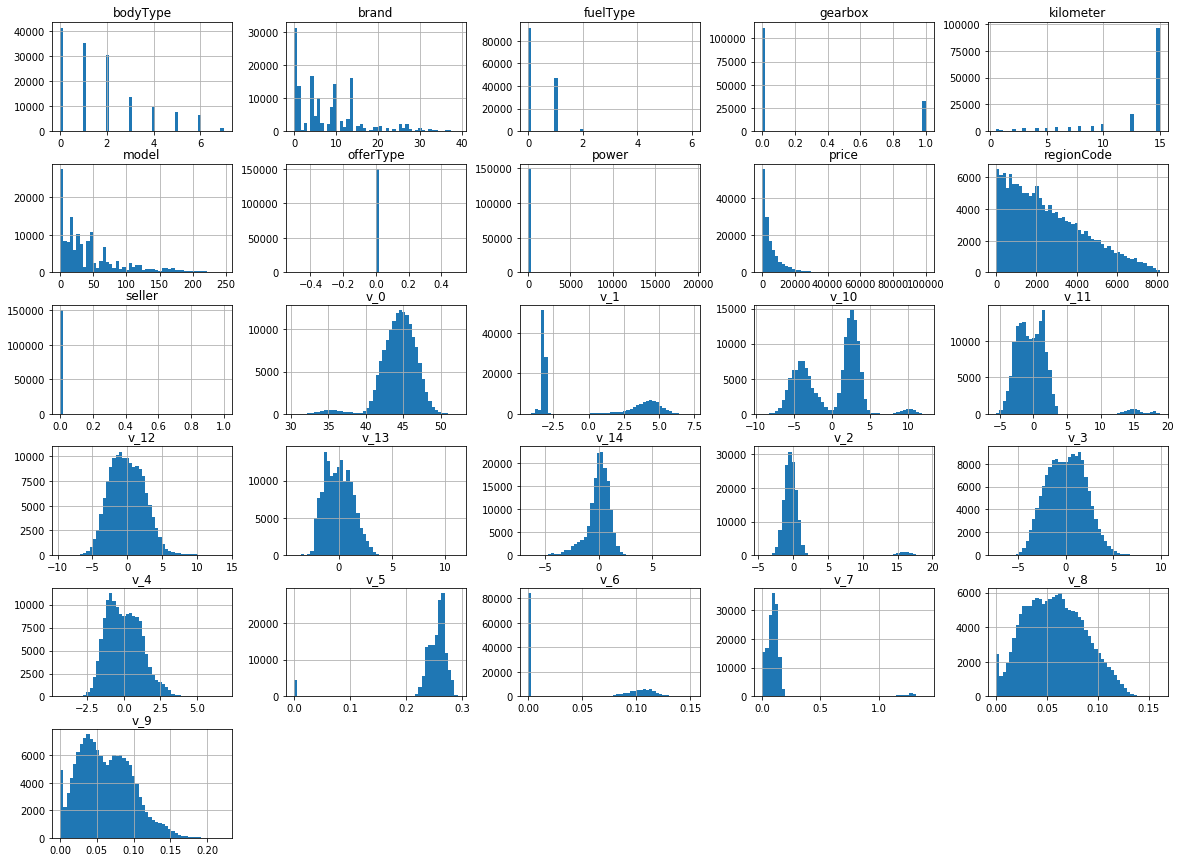

In [4]:
cols = [col for col in train_df.columns if col not in ['SaleID','name','regDate','creatDate']]
train_df[cols].hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
import mglearn
from pandas.plotting import scatter_matrix

# 使用散点图矩阵图，可以两两发现特征之间的联系(暂未实现).
# scatter_matrix(train_df[cols][:1000], marker='o',c=train_df['price'][:1000], hist_kwds={'bins':20}, cmap=mglearn.cm3)

### 皮尔逊相关性

In [6]:
train_df.corr(method='pearson').sort_values(by='price')['price']

v_3          -0.730946
kilometer    -0.440519
v_11         -0.275320
v_10         -0.246175
v_9          -0.206205
v_4          -0.147085
v_7          -0.053024
brand        -0.043799
v_13         -0.013993
seller       -0.002004
SaleID       -0.001043
name          0.002030
creatDate     0.002955
regionCode    0.014036
v_14          0.035911
v_1           0.060914
v_6           0.068970
v_2           0.085322
model         0.136983
v_5           0.164317
fuelType      0.200536
power         0.219834
bodyType      0.241303
gearbox       0.329075
regDate       0.611959
v_0           0.628397
v_8           0.685798
v_12          0.692823
price         1.000000
offerType          NaN
Name: price, dtype: float64

### 数据概览

训练集

- model: 149999
- bodyType: 145494
- fuelType: 141320
- gearbox: 144019
- notRepairedDamage: 0.0, 1.0, -(缺失)

测试集

- bodyType: 48587
- fuelType: 47107
- gearbox: 48090


In [7]:
train_df.head(10)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
5,5,137642,20090602,24.0,10,0.0,1.0,0.0,109,10.0,...,0.260246,0.000518,0.119838,0.090922,0.048769,1.885526,-2.721943,2.457660,-0.286973,0.206573
6,6,2402,19990411,13.0,4,0.0,0.0,1.0,150,15.0,...,0.267998,0.117675,0.142334,0.025446,0.028174,-4.902200,1.610616,-0.834605,-1.996117,-0.103180
7,7,165346,19990706,26.0,14,1.0,0.0,0.0,101,15.0,...,0.239506,0.000000,0.122943,0.039839,0.082413,3.693829,-0.245014,-2.192810,0.236728,0.195567
8,8,2974,20030205,19.0,1,2.0,1.0,1.0,179,15.0,...,0.263833,0.116583,0.144255,0.039851,0.024388,-4.925234,1.587796,0.075348,-1.551098,0.069433
9,9,82021,19980101,7.0,7,5.0,0.0,0.0,88,15.0,...,0.262473,0.068267,0.012176,0.010291,0.098727,-1.089584,0.600683,-4.186210,0.198273,-1.025822


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [9]:
train_df.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [10]:
test_df.head(10)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,...,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,...,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
2,150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,...,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033
3,150003,50688,20100405,0.0,0,0.0,0.0,1.0,160,7.0,...,0.260466,0.106727,0.081146,0.075971,0.048268,-4.864637,0.505493,1.870379,0.366038,1.312775
4,150004,161428,19970703,26.0,14,2.0,0.0,0.0,75,15.0,...,0.250999,0.000000,0.077806,0.028600,0.081709,3.616475,-0.673236,-3.197685,-0.025678,-0.101290
5,150005,2741,20000504,0.0,0,2.0,1.0,0.0,90,15.0,...,0.261375,0.107652,0.107152,0.025683,0.036749,-3.855120,1.909129,-1.690068,-1.108560,0.210864
6,150006,180443,20040208,4.0,4,0.0,1.0,0.0,150,15.0,...,0.264218,0.000000,0.129987,0.070556,0.036394,2.276785,-2.317462,1.085393,-1.096463,0.209925
7,150007,3787,20041101,104.0,4,0.0,1.0,1.0,204,15.0,...,0.267521,0.115419,0.122322,0.064023,0.023538,-5.463922,0.689999,1.825831,-1.307164,-1.544413
8,150008,17976,20040908,228.0,13,3.0,3.0,0.0,0,12.5,...,0.243757,0.115915,0.007771,0.052089,0.141854,-4.820441,1.392983,-0.963445,2.471255,-2.126286
9,150009,111167,20020404,11.0,10,0.0,0.0,0.0,82,15.0,...,0.262957,0.000000,0.104400,0.053416,0.043451,2.755332,-1.754406,-0.627676,-0.952986,0.326046


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

In [12]:
test_df.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,48587.000000,47107.000000,48090.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,174999.500000,68542.223280,2.003393e+07,46.844520,8.056240,1.782185,0.373405,0.224350,119.883620,12.595580,...,0.248669,0.045021,0.122744,0.057997,0.062000,-0.017855,-0.013742,-0.013554,-0.003147,0.001516
std,14433.901067,61052.808133,5.368870e+04,49.469548,7.819477,1.760736,0.546442,0.417158,185.097387,3.908979,...,0.044601,0.051766,0.195972,0.029211,0.035653,3.747985,3.231258,2.515962,1.286597,1.027360
min,150000.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.160049,-5.411964,-8.916949,-4.123333,-6.112667
25%,162499.750000,11203.500000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243762,0.000044,0.062644,0.035084,0.033714,-3.700121,-1.971325,-1.876703,-1.060428,-0.437920
50%,174999.500000,52248.500000,2.003091e+07,29.000000,6.000000,1.000000,0.000000,0.000000,109.000000,15.000000,...,0.257877,0.000815,0.095828,0.057084,0.058764,1.613212,-0.355843,-0.142779,-0.035956,0.138799
75%,187499.250000,118856.500000,2.007110e+07,65.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265328,0.102025,0.125438,0.079077,0.087489,2.832708,1.262914,1.764335,0.941469,0.681163
max,199999.000000,196805.000000,2.015121e+07,246.000000,39.000000,7.000000,6.000000,1.000000,20000.000000,15.000000,...,0.291618,0.153265,1.358813,0.156355,0.214775,12.338872,18.856218,12.950498,5.913273,2.624622


## 空值可视化

### 方法1

In [13]:
train_df.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

### 方法2

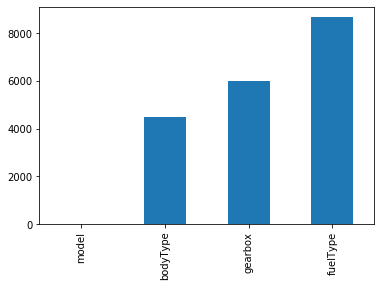

In [14]:
missing_data = train_df.isnull().sum()
missing_data = missing_data[missing_data>0]
missing_data.sort_values(inplace=True)
missing_data.plot.bar()

### 方法3

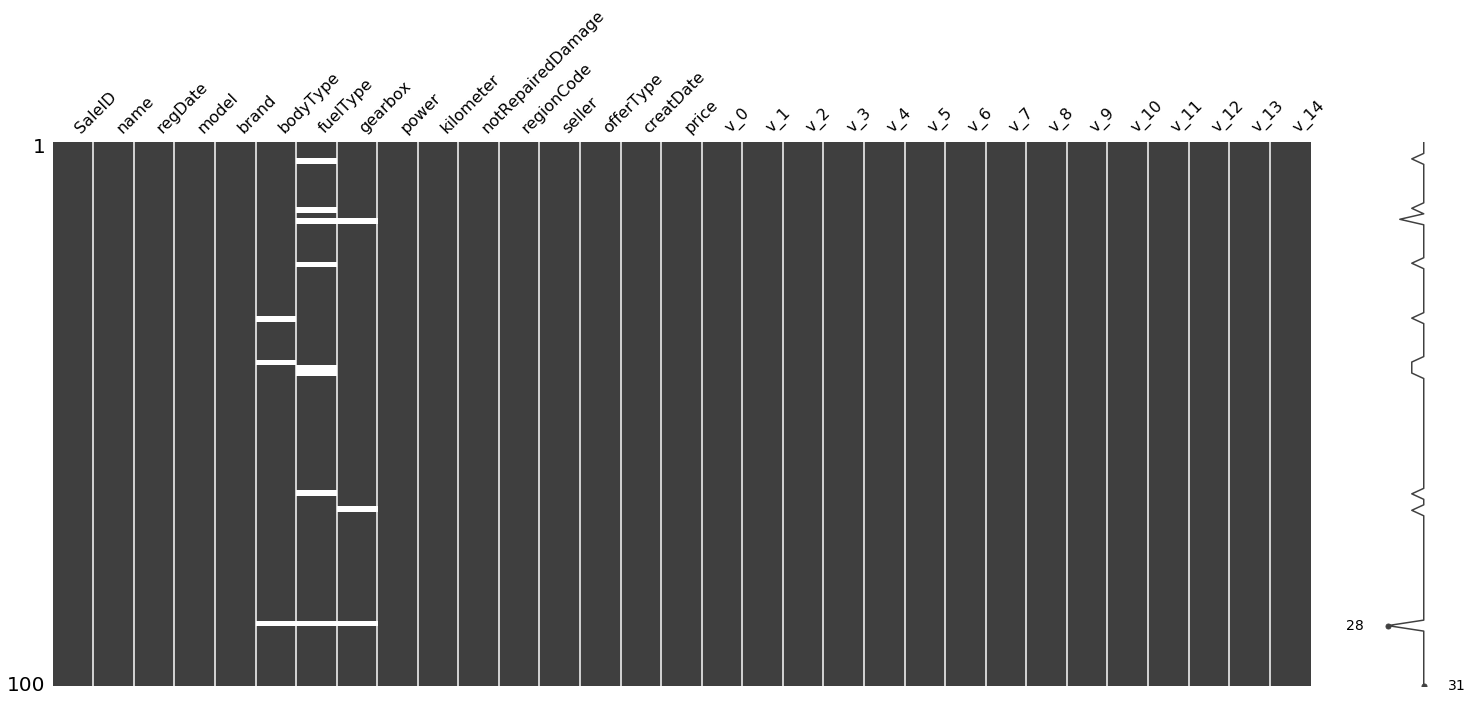

In [15]:
# 缺失值可视化
import missingno as msno

# pip install missingno
msno.matrix(train_df.sample(100, random_state=666))

### 方法4

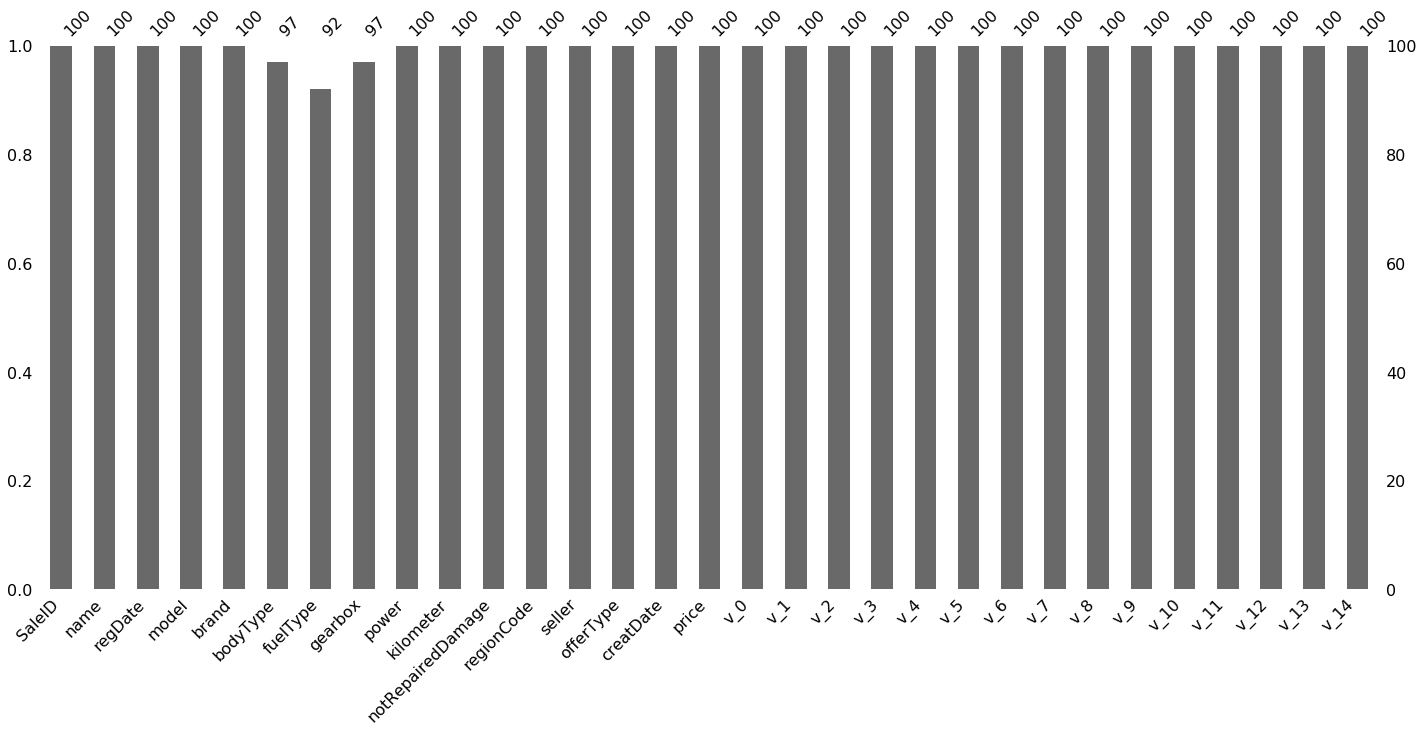

In [16]:
msno.bar(train_df.sample(100, random_state=666))

### notRepairedDamage

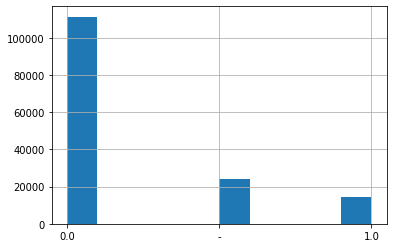

In [17]:
train_df['notRepairedDamage'].hist()

In [18]:
train_df['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

### power

In [19]:
train_df['power'].value_counts()

0       12829
75       9593
150      6495
60       6374
140      5963
        ...  
1597        1
1596        1
572         1
316         1
575         1
Name: power, Length: 566, dtype: int64

### seller

In [20]:
train_df['seller'].value_counts()

0    149999
1         1
Name: seller, dtype: int64

### offerType

In [21]:
train_df['offerType'].value_counts()

0    150000
Name: offerType, dtype: int64

## 预测值

count    147751.000000
mean       5358.283761
std        5749.035535
min          11.000000
25%        1300.000000
50%        3200.000000
75%        7400.000000
max       30000.000000
Name: price, dtype: float64


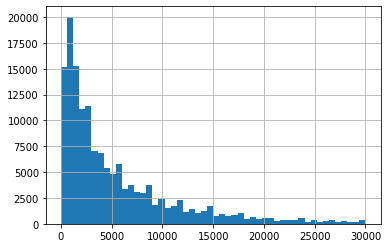

In [22]:
print(train_df[train_df['price']<=30000]['price'].describe())
train_df[train_df['price']<=30000]['price'].hist(bins=50)
plt.show()

### 总体分布

TODO: 待补充

In [23]:
# import pandas_profiling

# pfr = pandas_profiling.ProfileReport(train_df)
# pfr.to_file('./example.html')

## 数字特征分析

In [24]:
numeric_features = ['regDate', 'power', 'kilometer', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


### 皮尔逊相关性

In [25]:
# 1. 皮尔逊相关性
correlation = train_df[numeric_features].corr(method='pearson')
correlation['price'].sort_values()

v_3         -0.730946
kilometer   -0.440519
v_11        -0.275320
v_10        -0.246175
v_9         -0.206205
v_4         -0.147085
v_7         -0.053024
v_13        -0.013993
creatDate    0.002955
v_14         0.035911
v_1          0.060914
v_6          0.068970
v_2          0.085322
v_5          0.164317
power        0.219834
regDate      0.611959
v_0          0.628397
v_8          0.685798
v_12         0.692823
price        1.000000
Name: price, dtype: float64

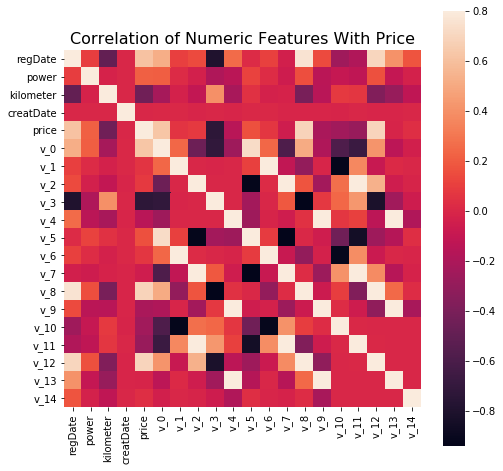

In [26]:
plt.subplots(figsize=(8, 8))
plt.title('Correlation of Numeric Features With Price', y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8)

### 偏度和峰值

In [27]:
for col in numeric_features:
    print('{:15}'.format(col),
         'Skewness: {:05.2f}'.format(train_df[col].skew()),
         '  ',
         'Kurtosis: {:06.2f}'.format(train_df[col].kurt()),          
         
         )

regDate         Skewness: 00.03    Kurtosis: -00.70
power           Skewness: 65.86    Kurtosis: 5733.45
kilometer       Skewness: -1.53    Kurtosis: 001.14
creatDate       Skewness: -79.01    Kurtosis: 6881.08
price           Skewness: 03.35    Kurtosis: 019.00
v_0             Skewness: -1.32    Kurtosis: 003.99
v_1             Skewness: 00.36    Kurtosis: -01.75
v_2             Skewness: 04.84    Kurtosis: 023.86
v_3             Skewness: 00.11    Kurtosis: -00.42
v_4             Skewness: 00.37    Kurtosis: -00.20
v_5             Skewness: -4.74    Kurtosis: 022.93
v_6             Skewness: 00.37    Kurtosis: -01.74
v_7             Skewness: 05.13    Kurtosis: 025.85
v_8             Skewness: 00.20    Kurtosis: -00.64
v_9             Skewness: 00.42    Kurtosis: -00.32
v_10            Skewness: 00.03    Kurtosis: -00.58
v_11            Skewness: 03.03    Kurtosis: 012.57
v_12            Skewness: 00.37    Kurtosis: 000.27
v_13            Skewness: 00.27    Kurtosis: -00.44
v_14     

### 分布可视化

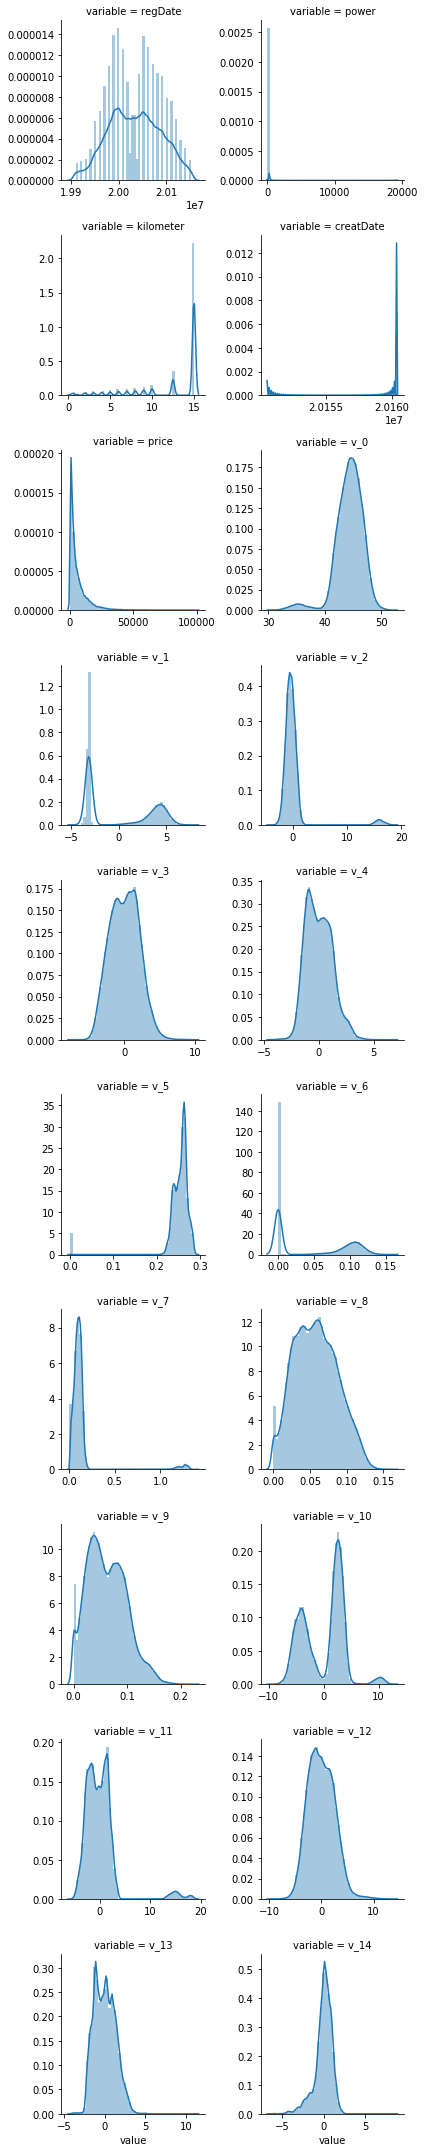

In [28]:
f = pd.melt(train_df, value_vars=numeric_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

### 数字特征相互之间的关系可视化

In [29]:
# 运行时间太久
# sns.set()
# sns.pairplot(train_df[numeric_features], size=2, kind='scatter', diag_kind='kde')
# plt.show()

## 分类特征分析

In [30]:
categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']


### 类型数据量

In [31]:
for col in categorical_features:
    print('{0}: {1}'.format(col, train_df[col].nunique()))

name: 99662
model: 248
brand: 40
bodyType: 8
fuelType: 7
gearbox: 2
notRepairedDamage: 3
regionCode: 7905


### 类别特征箱型图可视化

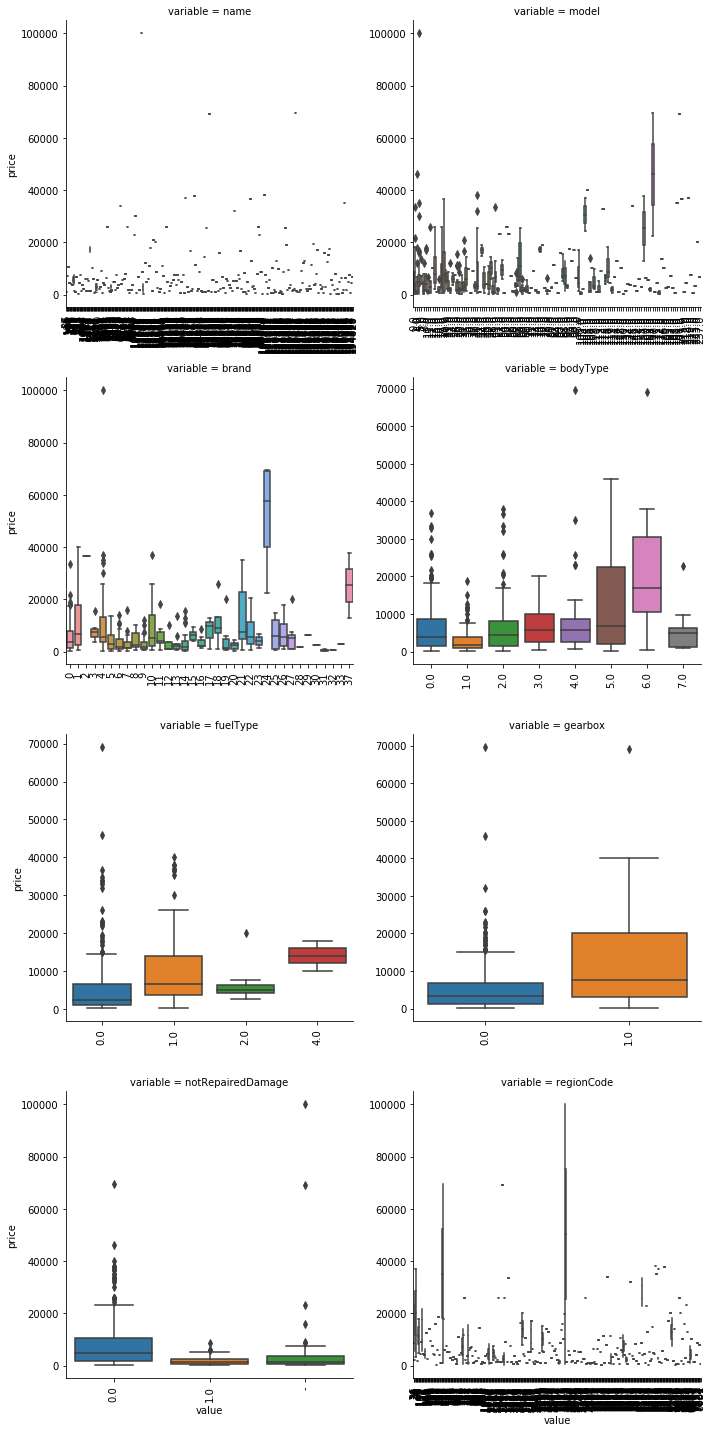

In [32]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(train_df.sample(random_state=666, n=500), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'price')

### 类别特征的小提琴可视化

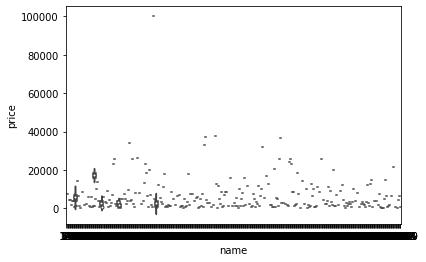

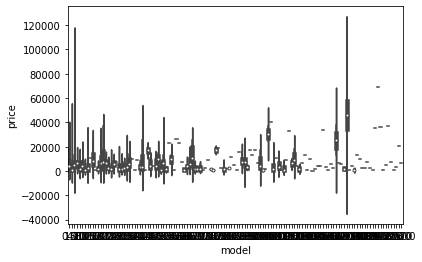

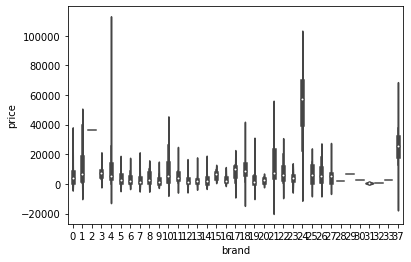

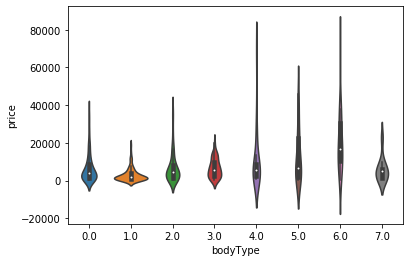

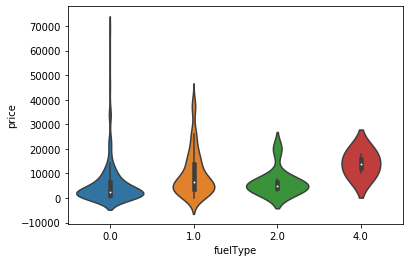

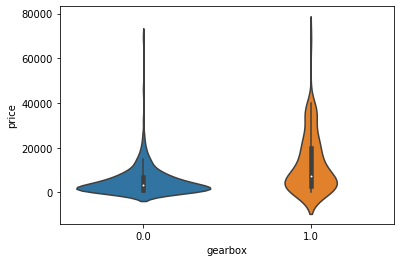

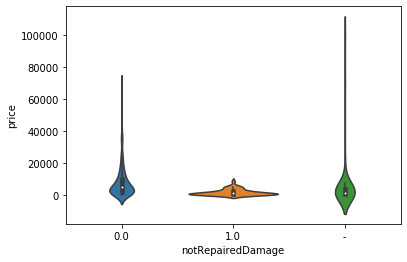

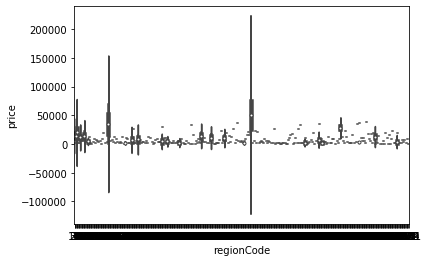

In [33]:
for col in categorical_features:
    sns.violinplot(x=col, y='price', data=train_df.sample(random_state=666, n=500))
    plt.show()

### 类别特征的柱形图可视化

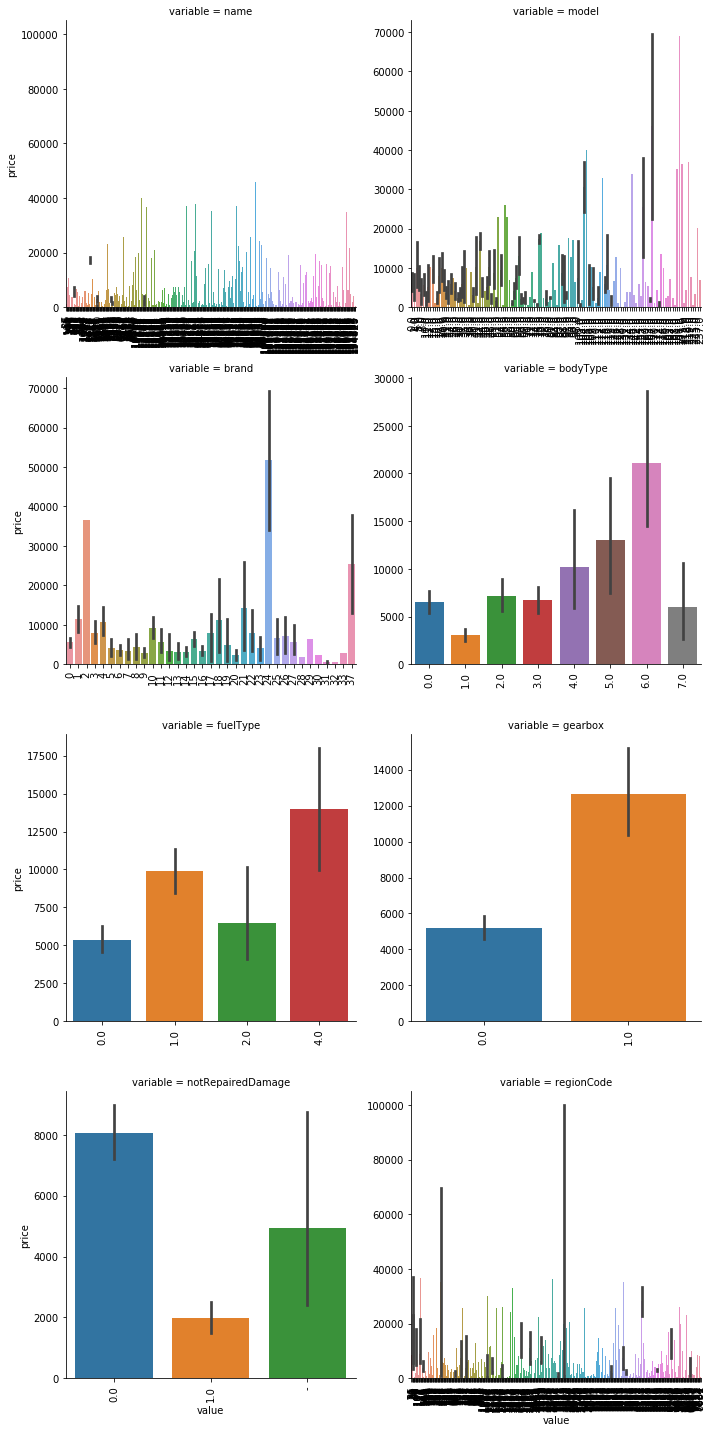

In [34]:
def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(train_df.sample(random_state=666, n=500), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(bar_plot, 'value', 'price')

### 类别特征的每个类别频数可视化

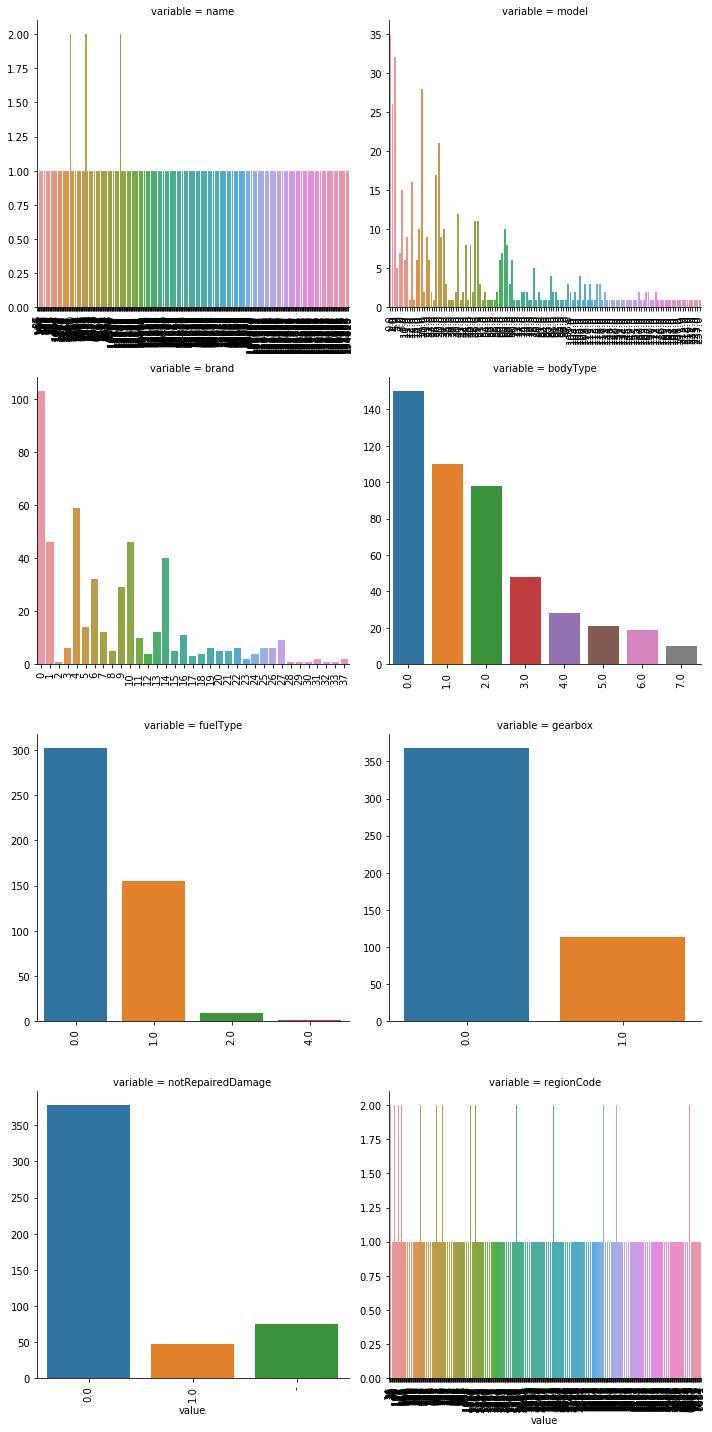

In [35]:
def count_plot(x, **kwargs):
    sns.countplot(x=x)
    x = plt.xticks(rotation=90)

f = pd.melt(train_df.sample(random_state=666, n=500), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(count_plot, 'value')

## 模型

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

xgr = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=10) 


train_x_df, test_x_df, train_y_df, test_y_df = train_test_split(train_df, train_df['price'], random_state=666)


feature_cols = [col for col in train_df.columns if col not in ['SaleID','name','regDate','creatDate','model','brand','regionCode','seller','notRepairedDamage','price','offerType']]
feature_cols = [col for col in feature_cols if 'Type' not in col]
train_x_df = train_x_df[feature_cols]
train_y_df = train_y_df

test_x_df = test_x_df[feature_cols]

xgr.fit(train_x_df, train_y_df)

pred_test_xgb=xgr.predict(test_x_df)
score_train = mean_absolute_error(test_y_df, pred_test_xgb)
print(score_train)

In [ ]:
# 导出预测值
X_test = test_df[feature_cols]

result_df = test_df[['SaleID']]
result_df['price'] = xgr.predict(X_test)
result_df.to_csv('sample_submit.csv', index=False)